In [4]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [5]:
dir_ = Path('./imagedata')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    
    labels = [str(filepath[i]).replace('\\', '/').split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,imagedata\charmander\charmander_851.jpg,charmander
1,imagedata\purin\purin_329.jpg,purin
2,imagedata\pikachu\pikachu_1463.jpg,pikachu
3,imagedata\king\king_482.jpg,king
4,imagedata\king\king_289.jpg,king


In [6]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 5157

Number of different labels: 4

Labels: ['charmander' 'purin' 'pikachu' 'king']


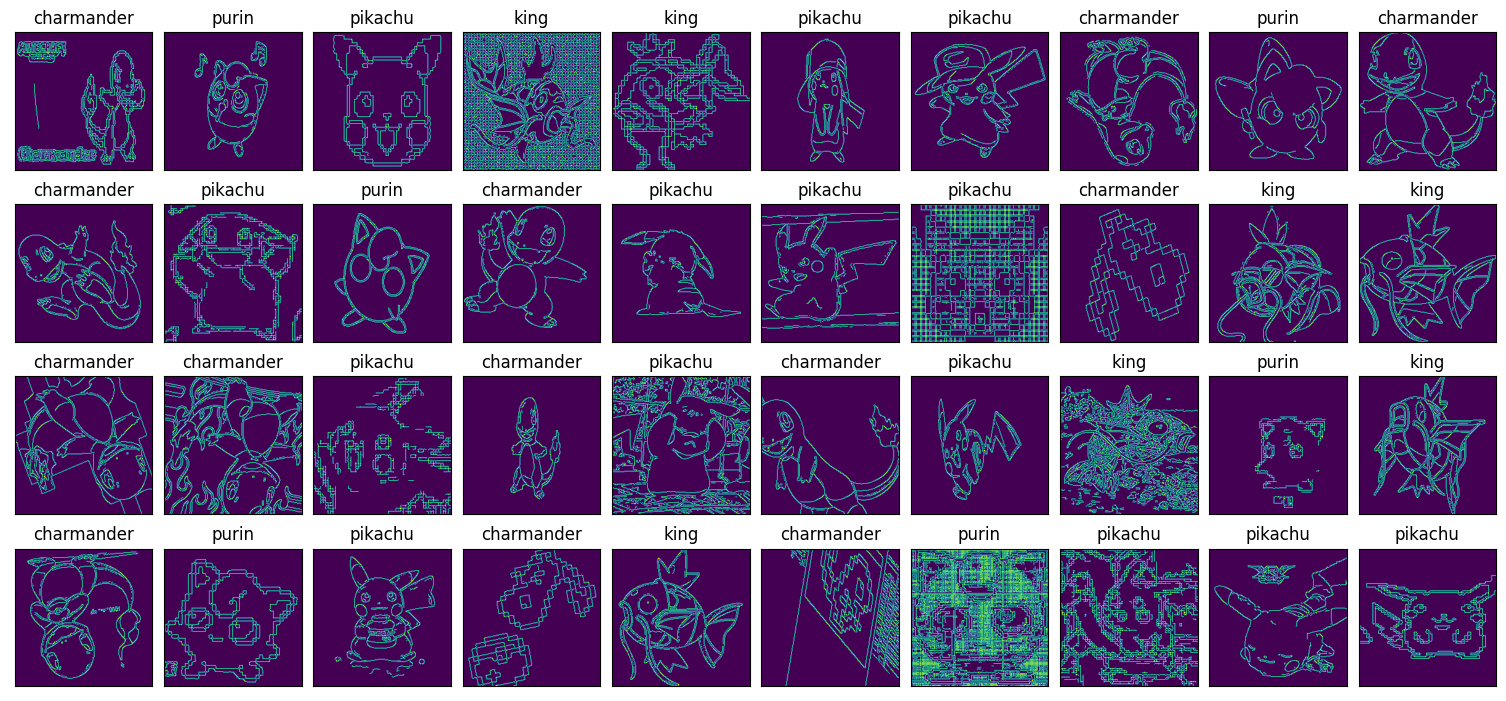

In [7]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [8]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((4641, 2), (516, 2))

In [9]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('./imagedata',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('./imagedata',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 4127 images belonging to 4 classes.
Found 1030 images belonging to 4 classes.


In [10]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.5))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=4, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 54, 54, 32)        0         
                                                                 
 flatten (Flatten)           (None, 93312)             0

In [11]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [12]:
models = {
    #"DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    #"MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    #"DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    #"EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    #"EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    #"InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    #"ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    #"ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    #"ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    #"VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    #"VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    #"Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

In [13]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

Found 4177 validated image filenames belonging to 4 classes.
Found 464 validated image filenames belonging to 4 classes.
Found 516 validated image filenames belonging to 4 classes.




In [14]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
    # 라벨 개수가 5개이기 때문에 Dencs도 5로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [15]:
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

MobileNetV3Large     trained in 49.46 sec


In [16]:
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

17/17 [==============================] - 6s 260ms/step
**MobileNetV3Large has a 84.11% accuracy on the test set**


In [92]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.9116,0.9147,238.25
1,MobileNetV3Large,0.8384,0.8295,56.16
2,MobileNetV2,0.8642,0.8236,48.61
3,ResNet50,0.8017,0.8062,162.61
4,VGG16,0.8405,0.7810,316.98


## DenseNet201

In [93]:
import time
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
start = time.time()
history = model.fit(train_images,validation_data=val_images,epochs=7)
train_time = time.time() - start

Found 4177 validated image filenames belonging to 4 classes.
Found 464 validated image filenames belonging to 4 classes.
Found 516 validated image filenames belonging to 4 classes.
Epoch 1/7
131/131 [==============================] - 223s 2s/step - loss: 0.4467 - accuracy: 0.8374 - val_loss: 0.2457 - val_accuracy: 0.9224
Epoch 2/7
131/131 [==============================] - 228s 2s/step - loss: 0.2452 - accuracy: 0.9105 - val_loss: 0.2081 - val_accuracy: 0.9267
Epoch 3/7
131/131 [==============================] - 213s 2s/step - loss: 0.1867 - accuracy: 0.9301 - val_loss: 0.1935 - val_accuracy: 0.9353
Epoch 4/7
131/131 [==============================] - 205s 2s/step - loss: 0.1286 - accuracy: 0.9562 - val_loss: 0.1818 - val_accuracy: 0.9353
Epoch 5/7
131/131 [==============================] - 200s 2s/step - loss: 0.1017 - accuracy: 0.9636 - val_loss: 0.2322 - val_accuracy: 0.9203
Epoch 6/7
131/131 [==============================] - 202s 2s/step - loss: 0.0970 - accuracy: 0.9643 - val_los

In [58]:
import datetime
result_list = str(datetime.timedelta(seconds=train_time)).split(".")
result = result_list[0]

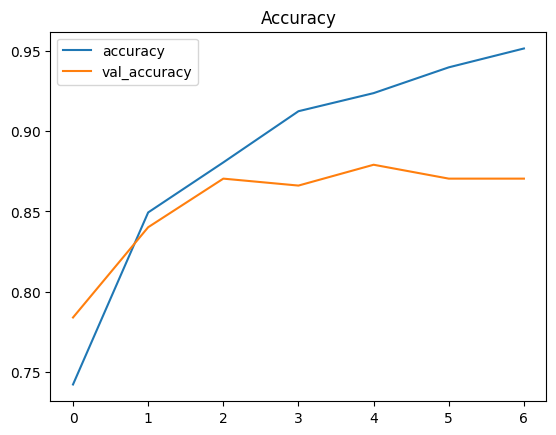

In [51]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [94]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')
printmd(result)

17/17 [==============================] - 26s 1s/step


# Accuracy on the test set: 93.60%

0:01:23

(1, 224, 224, 3)
1/1 [==============================] - 0s 37ms/step


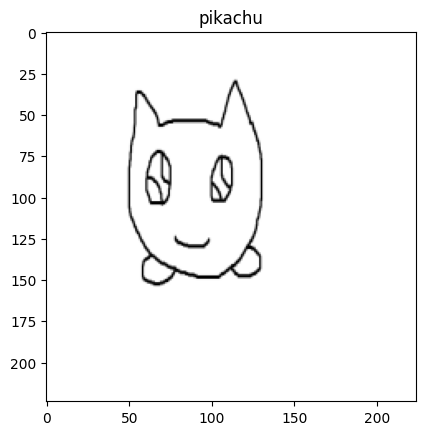

In [22]:
import cv2
test_img = cv2.imread('purin.png', cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
#edge = cv2.Canny(test_img, 120, 200)
#edge = cv2.merge([edge,edge,edge])
#edge = edge.reshape((1,224,224,3))
test_img = test_img.reshape((1, 224, 224, 3))
print(test_img.shape)
prediction = model.predict(test_img)
prediction = np.argmax(prediction,axis=1)
plt.title(labels[prediction[0]])
plt.imshow(test_img[0])
plt.savefig('result.png')

In [67]:
model.save('DensNet121_model.h5')

## MobileNetV3Large

In [18]:
import time
import datetime

train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.MobileNetV3Large)
start = time.time()
history = model.fit(train_images,validation_data=val_images,epochs=7)
train_time = time.time() - start

result_list = str(datetime.timedelta(seconds=train_time)).split(".")
result = result_list[0]

Found 4177 validated image filenames belonging to 4 classes.
Found 464 validated image filenames belonging to 4 classes.
Found 516 validated image filenames belonging to 4 classes.
Epoch 1/7
131/131 [==============================] - 48s 328ms/step - loss: 0.6366 - accuracy: 0.7558 - val_loss: 0.5042 - val_accuracy: 0.7845
Epoch 2/7
131/131 [==============================] - 39s 297ms/step - loss: 0.4000 - accuracy: 0.8504 - val_loss: 0.3411 - val_accuracy: 0.8642
Epoch 3/7
131/131 [==============================] - 39s 298ms/step - loss: 0.3289 - accuracy: 0.8820 - val_loss: 0.3176 - val_accuracy: 0.8815
Epoch 4/7
131/131 [==============================] - 39s 297ms/step - loss: 0.2748 - accuracy: 0.9042 - val_loss: 0.2817 - val_accuracy: 0.9052
Epoch 5/7
131/131 [==============================] - 39s 298ms/step - loss: 0.2369 - accuracy: 0.9145 - val_loss: 0.2728 - val_accuracy: 0.9009
Epoch 6/7
131/131 [==============================] - 40s 302ms/step - loss: 0.1969 - accuracy: 0.92

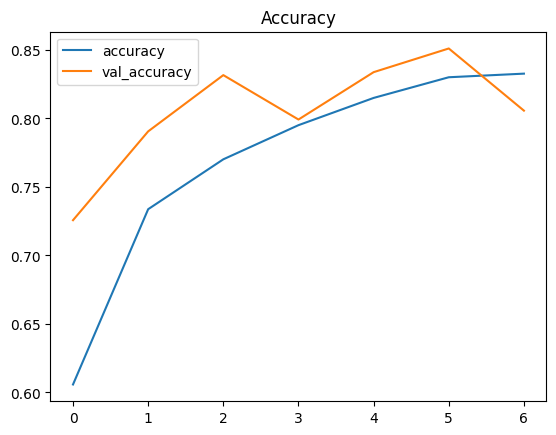

In [59]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [19]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')
printmd(result)

17/17 [==============================] - 6s 257ms/step


# Accuracy on the test set: 88.57%

0:04:42

## MobileNetV2

In [100]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.MobileNetV2)
start = time.time()
history = model.fit(train_images,validation_data=val_images,epochs=7)
train_time = time.time() - start

result_list = str(datetime.timedelta(seconds=train_time)).split(".")
result = result_list[0]

Found 4177 validated image filenames belonging to 4 classes.
Found 464 validated image filenames belonging to 4 classes.
Found 516 validated image filenames belonging to 4 classes.
Epoch 1/7
131/131 [==============================] - 47s 331ms/step - loss: 0.5490 - accuracy: 0.7984 - val_loss: 0.3002 - val_accuracy: 0.8944
Epoch 2/7
131/131 [==============================] - 41s 314ms/step - loss: 0.2854 - accuracy: 0.8987 - val_loss: 0.2860 - val_accuracy: 0.8750
Epoch 3/7
131/131 [==============================] - 42s 318ms/step - loss: 0.1899 - accuracy: 0.9344 - val_loss: 0.2937 - val_accuracy: 0.8922
Epoch 4/7
131/131 [==============================] - 42s 319ms/step - loss: 0.1473 - accuracy: 0.9471 - val_loss: 0.2100 - val_accuracy: 0.9289
Epoch 5/7
131/131 [==============================] - 43s 329ms/step - loss: 0.1246 - accuracy: 0.9540 - val_loss: 0.2572 - val_accuracy: 0.9203
Epoch 6/7
131/131 [==============================] - 42s 324ms/step - loss: 0.0792 - accuracy: 0.97

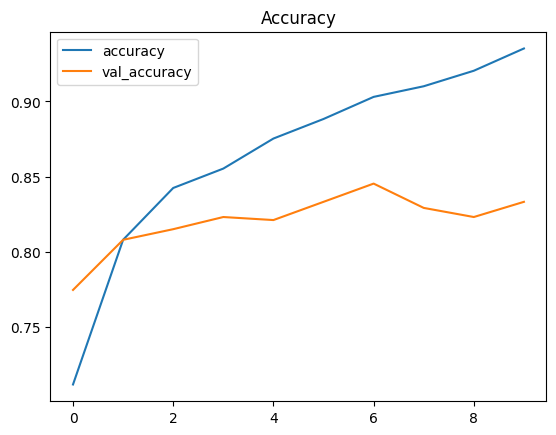

In [77]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [101]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')
printmd(result)

17/17 [==============================] - 6s 272ms/step


# Accuracy on the test set: 90.89%

0:04:58

In [20]:
model.save('MobileNetV2_model.h5')

## DenseNet121	

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet121)
history = model.fit(train_images,validation_data=val_images,epochs=5)

Found 8908 validated image filenames belonging to 5 classes.
Found 989 validated image filenames belonging to 5 classes.
Found 1100 validated image filenames belonging to 5 classes.
Epoch 1/5
279/279 [==============================] - 89s 293ms/step - loss: 0.7309 - accuracy: 0.7313 - val_loss: 0.5917 - val_accuracy: 0.7917
Epoch 2/5
279/279 [==============================] - 87s 313ms/step - loss: 0.4727 - accuracy: 0.8276 - val_loss: 0.4973 - val_accuracy: 0.8352
Epoch 3/5
279/279 [==============================] - 84s 302ms/step - loss: 0.3976 - accuracy: 0.8604 - val_loss: 0.4454 - val_accuracy: 0.8534
Epoch 4/5
279/279 [==============================] - 83s 297ms/step - loss: 0.3209 - accuracy: 0.8847 - val_loss: 0.4512 - val_accuracy: 0.8524
Epoch 5/5
 46/279 [===>..........................] - ETA: 1:02 - loss: 0.2297 - accuracy: 0.9178

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

In [6]:
!conda list tensorflow

# packages in environment at C:\Users\gkstj\anaconda3\envs\keras:
#
# Name                    Version                   Build  Channel
tensorflow                2.6.0           gpu_py39he88c5ba_0  
tensorflow-base           2.6.0           gpu_py39hb3da07e_0  
tensorflow-datasets       4.8.1                    pypi_0    pypi
tensorflow-estimator      2.10.0                   pypi_0    pypi
tensorflow-gpu            2.10.1                   pypi_0    pypi
tensorflow-io-gcs-filesystem 0.29.0                   pypi_0    pypi
tensorflow-metadata       1.12.0                   pypi_0    pypi


In [10]:
from tensorflow.python.client import device_lib
import tensorflow as tf

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False